#### 1.遍历所有的（flair,GlistrBoost_ManuallyCorrected）数据，检查数据是否整齐

In [1]:
import os
import sys

In [2]:
PATH = 'F:/brain/brain/TCGA-GBM/Pre-operative_TCGA_GBM_NIfTI_and_Segmentations'
list_dir=os.listdir(PATH)

In [3]:
list_dir

['TCGA-02-0006',
 'TCGA-02-0009',
 'TCGA-02-0011',
 'TCGA-02-0027',
 'TCGA-02-0033',
 'TCGA-02-0034',
 'TCGA-02-0037',
 'TCGA-02-0046',
 'TCGA-02-0047',
 'TCGA-02-0054',
 'TCGA-02-0059',
 'TCGA-02-0064',
 'TCGA-02-0068',
 'TCGA-02-0069',
 'TCGA-02-0070',
 'TCGA-02-0075',
 'TCGA-02-0085',
 'TCGA-02-0086',
 'TCGA-02-0087',
 'TCGA-02-0102',
 'TCGA-02-0106',
 'TCGA-02-0116',
 'TCGA-06-0119',
 'TCGA-06-0122',
 'TCGA-06-0130',
 'TCGA-06-0137',
 'TCGA-06-0138',
 'TCGA-06-0139',
 'TCGA-06-0142',
 'TCGA-06-0145',
 'TCGA-06-0149',
 'TCGA-06-0154',
 'TCGA-06-0158',
 'TCGA-06-0162',
 'TCGA-06-0164',
 'TCGA-06-0176',
 'TCGA-06-0177',
 'TCGA-06-0179',
 'TCGA-06-0182',
 'TCGA-06-0184',
 'TCGA-06-0185',
 'TCGA-06-0187',
 'TCGA-06-0188',
 'TCGA-06-0190',
 'TCGA-06-0192',
 'TCGA-06-0238',
 'TCGA-06-0240',
 'TCGA-06-0644',
 'TCGA-06-0646',
 'TCGA-06-1084',
 'TCGA-06-1802',
 'TCGA-06-2570',
 'TCGA-06-5408',
 'TCGA-06-5413',
 'TCGA-06-5417',
 'TCGA-06-6389',
 'TCGA-08-0355',
 'TCGA-08-0356',
 'TCGA-08-0359

In [13]:
import nibabel as nib
import skimage.io as io
import numpy as np

for i in list_dir:
    patient_path = PATH + '/' +i
    #print(patient_path)
    patient_dir = os.listdir(patient_path)
    #print(patient_dir)
    #print("----------------------------")
    #找到flair文件以及manuallycorrected文件
    #print(patient_dir[0])
    #print(patient_dir[2])
    
    flair = nib.load(patient_path + '/' + patient_dir[0])
    label = nib.load(patient_path + '/' + patient_dir[2]) 
        
    flair_arr = flair.get_fdata()
    label_arr = label.get_fdata()
        
    if flair_arr.shape == label_arr.shape:
        print('1')
    else:
        print('0')

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


####  上述结果显示，flair 与 manuallycorrect 文件的维度是一样的，可以直接生成模型输入输出的文件

#### 2.数据增强（暂时不做，先把整个网络跑通，再来做）

#### 3.数据处理，生成.npy文件（参考了GitHub上部分代码，决定把尺寸resize到144\*144\*144）(或者直接使用简易版，32\*32\*32)

In [14]:
#生成输入文件，输出文件
import skimage.transform as trans

flairs = []
labels = []
resize = (32,32,32)

for i in list_dir:
    patient_path = PATH + '/' +i
    patient_dir = os.listdir(patient_path)
    
    patient_flair_path = patient_path + '/' + patient_dir[0]
    flair_arr = io.imread(patient_flair_path, plugin = 'simpleitk')  
    flair_arr = (flair_arr - flair_arr.mean()) / flair_arr.std()
    
    flair_arr = trans.resize(flair_arr, resize, mode = 'constant')
    flairs.append(flair_arr)
    
    
    
    patient_label_path = patient_path + '/' + patient_dir[2]
    label_arr = io.imread(patient_label_path, plugin = 'simpleitk')
    label_arr[label_arr == 4] = 1
    label_arr[label_arr != 1] = 0    
    
    label_arr = trans.resize(label_arr, resize, mode = 'constant')
    labels.append(label_arr)

    
np.save('flairs',np.array(flairs)[..., np.newaxis].astype('float32'))
np.save('labels',np.array(labels)[..., np.newaxis].astype('float32'))
      
    

#### 4.构造一个简单的U-NET 3d

In [5]:

from keras.models import Input, Model
from keras.layers import Conv3D, Concatenate, MaxPooling3D, Reshape
from keras.layers import UpSampling3D, Activation, Permute

def level_block_3d(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv3D(dim, 3, activation=acti, padding='same')(m)
        m = MaxPooling3D()(n)
        m = level_block_3d(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling3D()(m)
        m = Concatenate(axis=4)([n, m])
    return Conv3D(dim, 3, activation=acti, padding='same')(m)

def UNet_3D(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='elu'):
    i = Input(shape=img_shape)
    o = level_block_3d(i, dim, depth, factor, acti)
    o = Conv3D(n_out, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

Using TensorFlow backend.


ImportError: cannot import name 'descriptor'

In [5]:
import keras.backend as K
def f1_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def f1_loss(y_true, y_pred):
    return -f1_score(y_true, y_pred)

Using TensorFlow backend.


ImportError: cannot import name 'descriptor'

#### 5.加载数据

In [15]:
x = np.load('flairs.npy')
y = np.load('labels.npy')

print("x: ", x.shape)
print("y: ", y.shape)

x:  (102, 32, 32, 32, 1)
y:  (102, 32, 32, 32, 1)


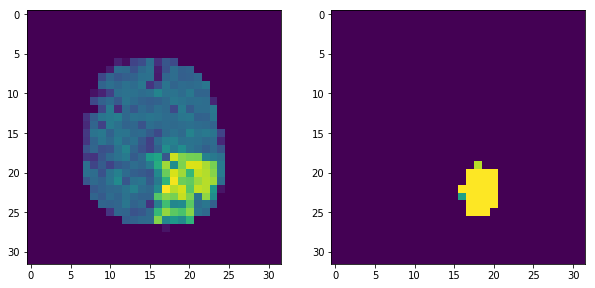

In [20]:
import random as r
import matplotlib.pyplot as plt

i = int(r.random() * x.shape[0])
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(x[i, int(x.shape[1]/2), :, :, 0])
plt.subplot(122)
plt.imshow(y[i, int(y.shape[1]/2), :, :, 0])
plt.show()

#### 6.训练

In [28]:
model = UNet_3D(x.shape[1:], dim=16, factor=1)

TypeError: max_pool3d() got an unexpected keyword argument 'data_format'